In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
from tqdm import tqdm
from numpy.random import rand


In [3]:
# t -> tmax dividido en pasos de dt
# t, t +dt 
# h : Hazzard Function, Occurrence Rate, Propensities
# 1/h tasa de ocurrencia
#save

class Poisson:

    def __init__(self, h=2, tmax=10, dt=0.01):
        self.h = h
        self.tmax = tmax
        self.dt = dt
        self.protein = 0
        self.t = 0


    def time_calculator(self):
        timer_arr = [0]
        timer_calc = [timer_arr.append(timer_arr[0]+self.dt) for i in range(self.tmax)]
        return timer_arr


    def poisson_sim(self):

        while self.t < self.tmax:

            if self.protein == 0:
                if rand() < self.h * self.dt:
                    self.protein = 1

            if self.protein == 1:
                return self.protein, self.t

            self.t += self.dt


    def poisson_bd(self):

        while self.t < self.tmax:

            if rand() < self.h * self.dt:
                self.protein += 1
            
            self.t += self.dt

        return self.protein
            
            

            

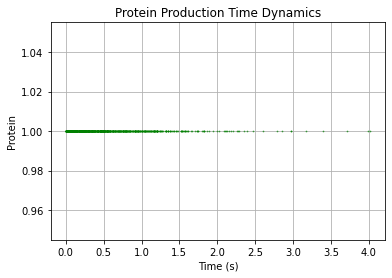

In [4]:
# rand_array = [ 1 for i in range(100000) if rand() < h * dt]
sims_array_1 = []
for i in range(1000):
    simulation_1 = Poisson(h=2, tmax=20, dt=0.01)
    sim_1 = simulation_1.poisson_sim()
    sims_array_1.append(sim_1[1])
    plt.plot(sim_1[1], sim_1[0], 'go', ms=0.8, alpha=0.6);

plt.xlabel('Time (s)')
plt.ylabel('Protein')
plt.title('Protein Production Time Dynamics')
plt.grid(True)


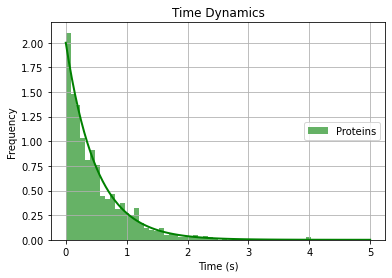

In [5]:
h = 2
time_exp_array = np.linspace(0,5,100)
plt.hist(sims_array_1, bins=50, color='green', alpha=0.6, density=True, label='Proteins');
plt.plot(time_exp_array, h*np.exp(- h * time_exp_array), 'g', lw=2)
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Time Dynamics')
plt.grid(True)
plt.legend(loc=7)

Text(0.5, 1.0, 'Time Dynamics')

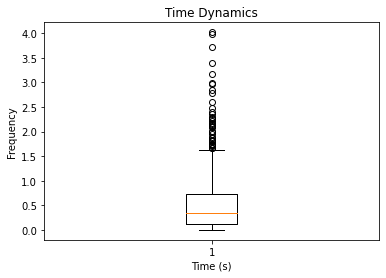

In [6]:
plt.boxplot(sims_array_1);
plt.xlabel('Time (s)')
plt.ylabel('Frequency')
plt.title('Time Dynamics')

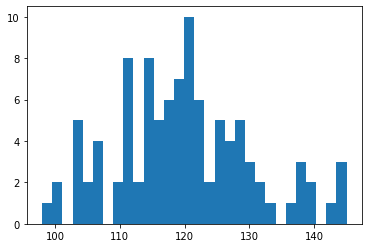

In [7]:
sim_2 = [Poisson(h=2, tmax=60, dt=0.01).poisson_bd() for i in range(100)]
plt.hist(sim_2, bins=30);

In [8]:
def state_reactions(self, species=1):
    """ Input: 
            Dictionary of Reactions where {Reaction Name: Reaction Propensity}
        Output: 
            Dictionary of Reaction Activity where {Reaction Name: Reaction Activity}
    """
    reactions_list = list(self.reactions.keys())
    propenisties_list = list(self.reactions.values())

    propensities_calculated = list(map(lambda propensity: -(1/propensity * species) * np.log(rand()), propenisties_list))
    reactions_activity_dict = dict(zip(reactions_list, propensities_calculated))

    return reactions_activity_dict

def min_argmin(self):
    """ Input: 
            Dictionary of Reaction Activity where {Reaction Name: Reaction Activity}
        Output: 
            Tau Time and Tau Argument
    """
    tau = np.min(list(self.reactions.values()))
    tau_arg = np.argmin(list(self.reactions.values()))

    tau_dict = {'tau': tau, 'tau_idx': tau_arg}

    return tau_dict

In [9]:
class Gillespie:
    def __init__(self, tmax=10, species = dict, reactions = dict, reaction_object = object):
        self.sampling_time = 0.001      # Sampling Time
        self.time = 0                   # Iitial Time
        self.reference_time = 0         # Reference Time
        self.tmax = tmax                # Total Time
        self.reactions = reactions      # {Reaction: Propensity}
        self.species = species          # {Species: Quantity}

    def simulate(self):
        """ 
            Performs Cesar Nieto et-al Gillespie algorithm
            for chemical reactions simulations.
        """
        while self.time < self.tmax:

            reactions_list = list(self.reactions.keys())
            propenisties_list = list(self.reactions.values())

            reaction_times = lambda propensity: -(1/(propensity)) * np.log(rand())
            calculated_propensities = map(reaction_times, propenisties_list)

            tau = np.min(propenisties_list)     # tau time
            q = np.argmin(propenisties_list)    # Reaction that occurs

            if self.time + tau < self.reference_time:
                pass

                self.time += tau
                
            else:
                self.time = self.reference_time  

                tarray.append(t)
                protarr.append(proteins)

                tref += samp_time   

            self.t += self.sampling_time
            reactions_activity = dict(zip(reactions_list, calculated_propensities))

        print(reactions_activity)



        

In [49]:
kr=100
gammar=10
t=0#tiempo
proteins=0#condicion inicial
tarray=[]
protarr=[]
samp_time=0.01
tref=0
tmax = 10

while t<tmax:
    
    if proteins > 0:

        tcrea = -(1/kr)*np.log(rand())
        tdeg = -(1/(gammar*proteins))*np.log(rand())

        tau = np.min([tcrea,tdeg])
        reac = np.argmin([tcrea,tdeg])
        
    if t + tau < tref:
        
        if reac == 0:
            proteins += 1
        else:
            proteins -= 1

        t += tau
        
    elif t + tau > tref:
        t = tref  

        tarray.append(t)
        protarr.append(proteins)

        tref += samp_time    

plt.plot(tarray,protarr)

NameError: name 'tau' is not defined

In [12]:
# rac = list(reactions.keys())
# prop = list(reactions.values())

# y = np.argmin(list(reactions.values()))
# print(y)

# sim_3 = Gillespie(kr=100, gamma=10, protein=0, tmax=10, h=2, reactions = reactions, species=species)
# sim_3.simulate()

# y = list(map(lambda propensity: -(1/propensity) * np.log(rand()), prop))
# print(y)

In [45]:
import copy as copy
import numpy as np

class ReactionModel:
    
    def __init__(self, reactions=dict,species=dict, propensities=dict, q=dict):
        self.reactions = reactions
        self.species = species 
        self.propensities = propensities
        self.q = q

    def show_model(self):
        print(self.reactions)
        print(self.species)
        print(self.propensities)
        print(self.q)
    
    def show_species(self):
        print(self.species)

    def show_reactions(self):
        print(self.reactions)

    def show_propensities(self):
        print(self.propensities)
    
    def calculate_propensities(self):
        
        complete_propensity = list(self.reactions.values())
        reaction_names = self.reactions.keys()
        species_copy = copy.copy(self.species)
        species_copy.update(self.propensities)

        species_calculus = []

        for i in range(len(complete_propensity)):
            propensities_array = []
            species_calculus.append(propensities_array)

            for k in complete_propensity[i]:
                propensities_array.append(species_copy[k])
                
        propensities_result = list(map(np.prod, species_calculus))
        
        return dict(zip(reaction_names, propensities_result))
    
    def create(self, name=str):
        self.species[name] += 1
    
    def destroy(self, name=str):
        self.species[name] -= 1


In [51]:


species = {
            'dna': 0, 
            'rna': 15, 
            'protein': 1000, 
            'complex': 1
            }

reactions = {
            'transcription': ['trc_c', 'dna'], 
            'translation':   ['trl_c', 'rna'], 
            'degradation':   ['pdeg_d', 'protein'], 
            'complex_c':     ['cmplx_c', 'dna', 'protein'],
            'complex_d':     ['cmplx_d', 'complex']
            }

propensities = {
                'trc_c':    0.005, 
                'trl_c':    0.167, 
                'pdeg_d':   np.log(2)/150, 
                'cmplx_c':  np.log(2)/3600,
                'cmplx_d':  0.005
            }

q = {
        'transcription': {'create': ['rna'],            'destroy': [None]}, 
        'translation':   {'create': ['protein'],        'destroy': [None]}, 
        'degradation':   {'create': [None],             'destroy': ['protein']}, 
        'complex_c':     {'create': ['comlpex'],        'destroy': ['dna', 'protein']},
        'complex_d':     {'create': ['dna', 'protein'], 'destroy': ['complex']}
    }        


model_2 = ReactionModel(
                        reactions=reactions, 
                        species=species, 
                        propensities=propensities,
                        q=q
                        )

print(model_2.calculate_propensities())
model_2.show_species()
model_2.create(name='protein')
model_2.show_species()
model_2.destroy(name='protein')
model_2.show_species()

{'transcription': 0.0, 'translation': 2.5050000000000003, 'degradation': 4.620981203732969, 'complex_c': 0.0, 'complex_d': 0.005}
{'dna': 0, 'rna': 15, 'protein': 1000, 'complex': 1}
{'dna': 0, 'rna': 15, 'protein': 1001, 'complex': 1}
{'dna': 0, 'rna': 15, 'protein': 1000, 'complex': 1}


In [13]:
list(map(lambda x, y, z: (x ** y) + z, [2,3], [1,4], [9,4]))

[11, 85]

In [14]:
propenisties_list_ = [0.005,0.167,np.log(2)/150]
quantity_list = [10,1000,10]
reaction_times = lambda propensity, quantity: -(1/(propensity * quantity)) * np.log(rand())
o = map(reaction_times, propenisties_list_, quantity_list)
list(o)

[26.784222736880064, 0.003585245853267824, 6.13976013479575]